In [1]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
#Importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from fredapi import Fred
import requests
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from IPython.display import HTML

# Data Preprocessing

## Data Sources
In our research, we'll be using multiple sources of oil prices data for each of three regions that are discussed in the paper: United States, Russia and Middle East.
Data for US crude oil benchmark West Texas Intermediate (WTI) is coming from two main sources provided by the U.S. government. The first one is the Energy Information Administration (EIA), which gives us information about the crude oil prices, including prices for derived oil products such as gasoline, jet fuel, diesel, heating oil and propane. The second source is the Federal Reserve Economic Data, St. Louis (FRED), maintained by the Federal Reserve Bank of St. Louis. FRED provides economic time-series data.
The time-series is obtained through open data tools and Application Programming Interface (API).

Middle East region is represented by Dubai crude which is commonly used as benchmark for the pricing of Middle Eastern oil, consisting of Dubai, Oman or Abu Dhabi oil.

Russian oil is represented by Urals blend. Data is obtained from Saint Petersburg International Mercantile Exchange https://spimex.com/en/

## Methodology

In order to analyze relations between oil and oil products we identified prices of crude oil and related oil products for three separate locations. Data was collected using RESTful API requests to query the government agencies sources such as EIA and IMF. In Python it's done with help of **requests** library allowing us to make the API calls with specified search parameters(time period, frequency, etc). 

In this study, we'll be focusing on the last five years, starting from October 2018 and going up to October 2023. We chose this time frame to assess how COVID-19, the Russia-Ukraine war, and Israel Hammas-Israel war affected petroleum prices. A five-year period provides a sufficiently large dataset for statistical analysis. This will allow us to perform the Exploratory Data Analysis(EDA) to draw meaningful conclusions about the relationships and correlations within the data. EDA is conducted using Python and popular data analysis libraries such as pandas, matplotlib, and seaborn. 

First, we imported oil prices into a Pandas DataFrame for easier work with tabular data. Next step was to organize data by combining all prices in one dataframe, naming columns and setting proper datatime index to manipulate the time-series. Subsequently, the data was inspected for missing values to ensure data quality. As a part of EDA to visualize the cleaned data, libraries  **matplotlib** and **seaborn** were used to illustrate how oil prices changed over time. The dataset contains prices for crude oil and petroleum products, to describe the relationships between them we conducted a correlation analysis by finding correlation coefficients and building correlation matrix. In our project we've plotted a heatmap to demonstrate how each oil product price correlates with others.

For further statistical analysis we calculated the daily returns on the prices and plotted the returns and the distribution of returns. Using returns instead of prices will make our series stationary, meaning that mean and variance does not change over time.

In addition to EDA we conducted Quantile-Quantile (Q-Q) analysis using **scipy** library to assess whether returns follow a particular theoretical distribution.

In next section we performed ARIMA modeling on crude oil prices to help us understand and predict how oil prices might change over time. By analyzing past prices relationships in different regions and influenced by geopolitical events, the model tries to identify trends and patterns that may repeat in the future. Predicting future prices is crucial for managing risks. We utilized Time Series Analysis module of the **statsmodels** Python package. To ensure the data stationarity we used Augmented Dickey-Fuller Test. Next step to set up the ARIMA model is to identify the optimal model parameters by building the autocorrelation function (ACF) and partial autocorrelation function (PACF) plots. We will be using **statsmodels.graphics.tsaplots** library, specifically the plot_acf and plot_pacf functions.

ARIMA models allowed us to run only univariate time series modeling. Since we evaluate multiple variables in our dataset, multivariate techniques must be used to describe the relationships.

Therefore we applied Principal Component Analysis (PCA) to identify the patterns in the data. Machine learning library **scikit-learn** provides methods that we used to implement the PCA on the oil price data.











In [3]:
# EIA API connection details
api_key = "WyIzc4qhpYE6rxEDvB216tCCuvSkHBwGLJ6ddpam"
eia_url = 'https://api.eia.gov/v2/petroleum/pri/spt/data/'

# List of oil products and codes
products = [
  {'name': 'Crude', 'code':'RWTC'},
  {'name': 'Gasoline', 'code':'EER_EPMRU_PF4_Y35NY_DPG'},
  {'name': 'Jet Fuel', 'code':'EER_EPJK_PF4_RGC_DPG'},
  {'name': 'Diesel', 'code':'EER_EPD2DXL0_PF4_Y35NY_DPG'},
  {'name': 'Heating Oil', 'code':'EER_EPD2F_PF4_Y35NY_DPG'},
  {'name': 'Propane', 'code':'EER_EPLLPA_PF4_Y44MB_DPG'}
  ]

start_date = '2019-01-01'
end_date = '2023-11-01'
date_range = pd.date_range(start_date, end_date, freq='D').strftime('%Y-%m-%d')

wti_df = pd.DataFrame(date_range, columns=['Date'])

for product in products: 
  # Query parameters 
  params = '?frequency=daily&data[0]=value&facets[series][]=%s&start=%s&end=%s&sort[0][column]=period&sort[0][direction]=desc&api_key=%s' % (product['code'], start_date, end_date, api_key)

  # Fetch the data using GET request
  data = requests.get(eia_url + params).json()
  df = pd.DataFrame(data['response']['data'])
  
  # Naming column with oil product name
  df.rename(columns={"value": product['name'], "period": 'Date'}, inplace=True) 

  # Merging price series
  wti_df = pd.merge(wti_df, df[['Date', product['name']]], on='Date') 
  
# Setting proper index
wti_df['Date'] = pd.to_datetime(df['Date'])
wti_df.set_index('Date', inplace=True)

# Convert oil products prices in $/gal to $/bbl multiplying by 42
# oil_products_df.iloc[:,1:6] = oil_products_df.iloc[:,1:6].multiply(42)

wti_df.head()

,Crude,Gasoline,Jet Fuel,Diesel,Heating Oil,Propane
Date,,,,,,
2023-10-31,46.31,1.394,1.607,1.705,1.687,0.641
2023-10-30,46.92,1.405,1.658,1.738,1.716,0.630
2023-10-27,47.76,1.408,1.711,1.778,1.753,0.635
2023-10-26,48.27,1.395,1.714,1.803,1.754,0.623
2023-10-25,49.58,1.413,1.758,1.822,1.790,0.628


In [4]:
# urals_df = pd.read_csv('data/Crude Oil Urals Europe CFR Spot Historical Data.csv', delimiter=';')
# urals_df = urals_df[['Date', 'Crude']]
# # Set the random seed for reproducibility
# for column in wti_df.columns[1:6]:
# # Generate a series of random values between 0.02 and 0.04
#   mean = (wti_df[column]/wti_df['Crude']).mean()
#   urals_df[column] = np.round(pd.Series(np.random.uniform(mean-0.0001, mean+0.0001, 1248)) * urals_df['Crude'], 3)


# # urals_df['Propane'] = pd.Series(np.random.uniform(0.01, 0.02, 1248)) * urals_df['Price']
# # Display the series
# urals_df['Date'] = pd.to_datetime(urals_df['Date'])
# urals_df.set_index('Date', inplace=True)
# urals_df.to_csv('data/oil_products_prices_russia.csv')
# print(urals_df)

In [5]:
urals_df = pd.read_csv('data/Crude Oil Urals Europe CFR Spot Historical Data.csv', delimiter=';')
urals_df = urals_df[['Date', 'Crude']]

drop_indices = np.random.choice(urals_df.index, 32, replace=False)
df_subset = urals_df.drop(drop_indices)

# urals_df['Date'] = pd.to_datetime(urals_df['Date'])

# df_subset.to_csv('data/oil_products_prices_russia.csv')

correlations = wti_df.corr()['Crude']
correlations = correlations.drop('Crude')

df_simulated_brent = pd.DataFrame(index=wti_df.index)
df_subset.index = wti_df.index

# correlations = correlations.drop('Crude')
for product, correlation in correlations.items():
    # Use the correlation to simulate data for Brent based on the product in df_wti

    

    simulated_data = wti_df[product] * correlation * np.random.uniform(0.99, 1.01, size=len(wti_df)) # + np.random.normal(scale=0.1, size=len(wti_df))
    # print(simulated_data)
    
    # Add the simulated data to df_brent
    df_subset[product] = np.round(simulated_data, 3)
    print(product)

# Display the updated df_brent DataFrame
print(df_subset)
df_subset.drop('Date', axis=1).to_csv('data/oil_products_prices_russia.csv')


Gasoline
Jet Fuel
Diesel
Heating Oil
Propane
                  Date  Crude  Gasoline  Jet Fuel  Diesel  Heating Oil  \
Date                                                                     
2023-10-31  11/01/2023  74.28     1.367     1.495   1.589        1.556   
2023-10-30  10/31/2023  75.80     1.376     1.536   1.610        1.582   
2023-10-27  10/30/2023  74.34     1.373     1.601   1.637        1.598   
2023-10-26  10/27/2023  74.81     1.360     1.591   1.669        1.627   
2023-10-25  10/26/2023  75.20     1.370     1.634   1.678        1.641   
...                ...    ...       ...       ...     ...          ...   
2019-01-22  01/07/2019  57.75     2.361     2.654   2.813        2.703   
2019-01-21  01/04/2019  56.29     2.367     2.676   2.840        2.449   
2019-01-18  01/03/2019  53.88     2.380     2.666   2.760        2.686   
2019-01-17  01/02/2019  54.11     2.472     2.665   2.780        2.627   
2019-01-16  01/01/2019  50.62     2.402     2.656   2.758        2.

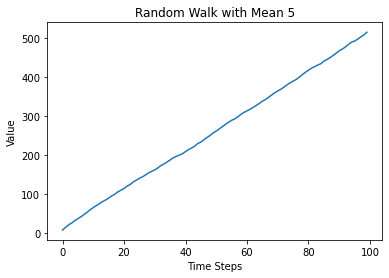

array([  7.68854552,  14.17876196,  20.71576789,  25.5597752 ,
        31.42776991,  36.68723002,  41.47163596,  47.2463955 ,
        53.02308086,  59.20658265,  65.09309106,  69.87613876,
        75.0132495 ,  80.12513827,  84.24706069,  89.18524379,
        94.6886584 ,  99.08251644, 105.32810556, 109.42835179,
       113.82184047, 119.78403501, 124.10786272, 130.70729022,
       135.08528427, 140.06562194, 143.61946733, 148.58538742,
       153.87562248, 157.72722851, 161.39340475, 166.60706068,
       172.67388953, 176.64897532, 181.62647385, 186.99407728,
       192.44847292, 196.17909224, 199.44548725, 202.8416786 ,
       208.27609599, 213.52406844, 217.66003436, 222.24298442,
       229.1929411 , 232.60997417, 238.7974494 , 244.34794283,
       249.73340194, 256.3628816 , 260.90771299, 266.48398659,
       272.47396291, 278.1395842 , 283.43096059, 288.49906978,
       292.01708819, 297.35849007, 303.76544636, 308.66908876,
       312.71744137, 316.5879922 , 321.699895  , 326.64

In [6]:
# Number of time steps
num_steps = 100

# Generate random walk values
random_walk = np.cumsum(np.random.normal(loc=5, size=num_steps))

# Plot the random walk
plt.plot(random_walk)
plt.title('Random Walk with Mean 5')
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.show()

random_walk


In [7]:
wti_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1216 entries, 2023-10-31 to 2019-01-16
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Crude        1216 non-null   float64
 1   Gasoline     1216 non-null   float64
 2   Jet Fuel     1216 non-null   float64
 3   Diesel       1216 non-null   float64
 4   Heating Oil  1216 non-null   float64
 5   Propane      1216 non-null   float64
dtypes: float64(6)
memory usage: 66.5 KB


# Functions

In [8]:
grades = ['WTI', 'Urals']

# Visualize prices
def plot_prices(dfs):
  """
  Plot multiple line plots horizontally for crude oil and oil products prices from different regions.

  Parameters:
   - dataframes (list): List of Pandas DataFrames containing prices.
   - regions (list): List of region names corresponding to the DataFrames.    
  """
  # Create a figure and axis
  fig, axes = plt.subplots(1, len(dfs),figsize=(15, 6), sharey=True)

  for df, grade, ax in zip(dfs, grades, axes):
    # Plot the WTI Crude Oil prices on the left axis
    ax.set_xlabel('Date')
    ax.set_ylabel(grade + ' Crude $/bbl')

    ax.plot(df.index, df['Crude'], color='k', label=(grade + ' Crude'))

    # Plot the oil products prices on the right axis

    ax2 = ax.twinx()
    ax2.set_ylabel('Oil Prodicts, $/gal')
    for column in df.columns[1:6]:
      ax2.plot(df.index, df[column], label=column)

    # Adjust the legend and show the plot
    # fig.legend(loc='upper center', ncol=len(df.columns))
    
  plt.tight_layout()
  plt.show()

# Output the dataset

def print_prices(dfs):    
    html = '<div style="display:flex">'
    for df, grade in zip(dfs, grades):
        html += '<div>'
        html += '<div style="display:flex; justify-content:center">'+grade+'</div>'
        html += '<div style="margin-right: 32px">'
        html += df.head().to_html()
        html += '</div></div>'
    html += '</div>'
    display(HTML(html))

def get_stats(dfs):
   html = '<div style="display:flex">'
   for df, grade in zip(dfs, grades):
       html += '<div>'
       html += '<div style="display:flex; justify-content:center">'+grade+'</div>'
       html += '<div style="margin-right: 32px">'
       html += df.describe().to_html()
       html += '</div></div>'
   html += '</div>'
   display(HTML(html))

def check_na(dfs):   
   html = '<div style="display:flex">'
   for df, grade in zip(dfs, grades):
       html += '<div>'
       html += '<div style="display:flex; justify-content:center">'+grade+'</div>'
       html += '<div style="margin-right: 32px">'
       html += df[df.isnull().any(axis=1)].to_html()
       html += '</div></div>'
   html += '</div>'
   display(HTML(html))

def calc_returns(dfs):
  """
  Estimating simple returns
  """
  returns_dfs = []
  html = '<div style="display:flex">'
  for df, grade in zip(dfs, grades):
    df = wti_df.pct_change().dropna()
    html += '<div>'
    html += '<div style="display:flex; justify-content:center">'+grade+'</div>'
    html += '<div style="margin-right: 32px">'
    html += df.head().to_html()
    html += '</div></div>'
    returns_dfs.append(df)
  html += '</div>'


  display(HTML(html))
  
  return returns_dfs

def plot_corr_matrix(dfs):

  num_plots = len(dfs)

  sns.set_theme(style="white")

  fig, axes = plt.subplots(1, num_plots, figsize=(6 * num_plots, 5), sharey=True, gridspec_kw={'wspace': 0.5})

  for i, df in enumerate(dfs):
    # Calculate the correlation matrix
    corr_matrix = df.corr()

    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

    # Plot the correlation matrix using Seaborn heatmap
    # plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, ax=axes[i])
    axes[i].set_title('Correlation Matrix - ' + grades[i] + ' Crude Oil/Oil Products Relationship')

  # Show the plot
  # plt.title('Correlation Matrix - WTI Crude Oil/Oil Products Relationship')
  plt.show()


In [9]:
print_prices([wti_df, urals_df])

In [10]:
# Basic statistics of the dataset
get_stats([wti_df, urals_df])

In [11]:
# Check for missing values and show rows with missing values
check_na([wti_df, urals_df])


In [12]:
wti_returns_df, urals_returns_df = calc_returns([wti_df, urals_df])

,Crude,Gasoline,Jet Fuel,Diesel,Heating Oil,Propane
Date,,,,,,
2023-10-30,0.013172,0.007891,0.031736,0.019355,0.017190,-0.017161
2023-10-27,0.017903,0.002135,0.031966,0.023015,0.021562,0.007937
2023-10-26,0.010678,-0.009233,0.001753,0.014061,0.000570,-0.018898
2023-10-25,0.027139,0.012903,0.025671,0.010538,0.020525,0.008026
2023-10-24,0.052642,0.046001,0.036974,0.030735,0.031285,0.047771
,Crude,Gasoline,Jet Fuel,Diesel,Heating Oil,Propane
Date,,,,,,
2023-10-30,0.013172,0.007891,0.031736,0.019355,0.017190,-0.017161
2023-10-27,0.017903,0.002135,0.031966,0.023015,0.021562,0.007937


The dataset contains no NA values

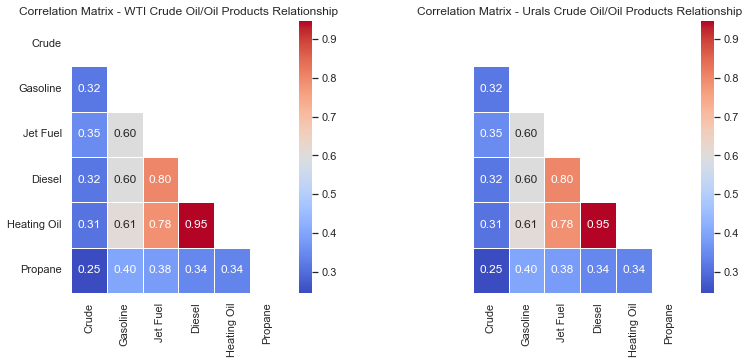

In [13]:
plot_corr_matrix([wti_returns_df, urals_returns_df])

### Russian Urals crude grade prices from Saint Petersburg International Mercantile Exchange

In [14]:
urals_df = pd.read_csv('data/oil_products_prices_russia.csv', sep=',', index_col='Date', parse_dates=True)
urals_df.head()

,Crude,Gasoline,Jet Fuel,Diesel,Heating Oil,Propane
Date,,,,,,
2023-10-31,74.28,1.367,1.495,1.589,1.556,0.492
2023-10-30,75.80,1.376,1.536,1.610,1.582,0.490
2023-10-27,74.34,1.373,1.601,1.637,1.598,0.490
2023-10-26,74.81,1.360,1.591,1.669,1.627,0.480
2023-10-25,75.20,1.370,1.634,1.678,1.641,0.484


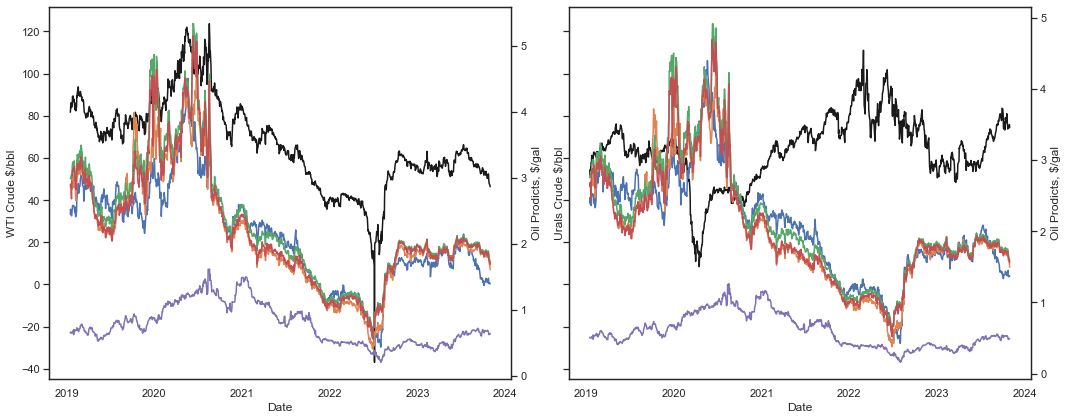

In [15]:
plot_prices([wti_df, urals_df])

## Dubai Crude prices in $ per barrel from International Monetary Fund API

In [16]:
# Obtaining Dubai Crude time-series from IMF using API query
url = 'http://dataservices.imf.org/REST/SDMX_JSON.svc/CompactData/PCPS/M.W00.POILDUB.USD'
data = (requests.get(url).json()
        ['CompactData']['DataSet']['Series'])

# Preparing the data
data_list = [[obs.get('@TIME_PERIOD'), obs.get('@OBS_VALUE')]
             for obs in data['Obs']]

# Create dataframe from array of dates and values
dubai_crude_df = pd.DataFrame(data_list, columns=['Date', 'Dubai Crude'])

# Setting datetime index
dubai_crude_df['Date'] = pd.to_datetime(dubai_crude_df['Date'])
dubai_crude_df.set_index(['Date'], inplace=True)

# Leaving 2 decimal palces
dubai_crude_df['Dubai Crude'] = dubai_crude_df['Dubai Crude'].astype(float).round(2)

dubai_crude_df.head()

,Dubai Crude
Date,
1990-01-01,17.50
1990-02-01,16.68
1990-03-01,15.76
1990-04-01,14.25
1990-05-01,14.65


<AxesSubplot:>

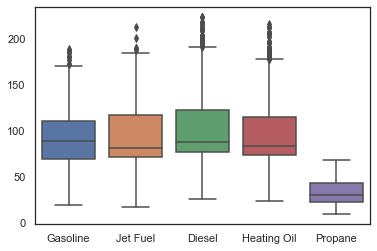

In [17]:
# Plotting blox plot to identify the outliers, oil products price was multipled by 42 to get comparable prices
sns.boxplot(data=wti_df.iloc[:,1:6].multiply(42))

## Stationarity test

In [18]:
for product in wti_returns_df:
    print("\n", product)
    adf = adfuller(wti_returns_df[product])
    print("ADF Statistic: %f" % adf[0])
    print("p-value: %f" % adf[1])  
    


 Crude
ADF Statistic: -10.899079
p-value: 0.000000

 Gasoline
ADF Statistic: -8.933305
p-value: 0.000000

 Jet Fuel
ADF Statistic: -16.735069
p-value: 0.000000

 Diesel
ADF Statistic: -14.245869
p-value: 0.000000

 Heating Oil
ADF Statistic: -25.108086
p-value: 0.000000

 Propane
ADF Statistic: -35.186572
p-value: 0.000000


Results of the tests show our data is stationary since p-values are extremely low.

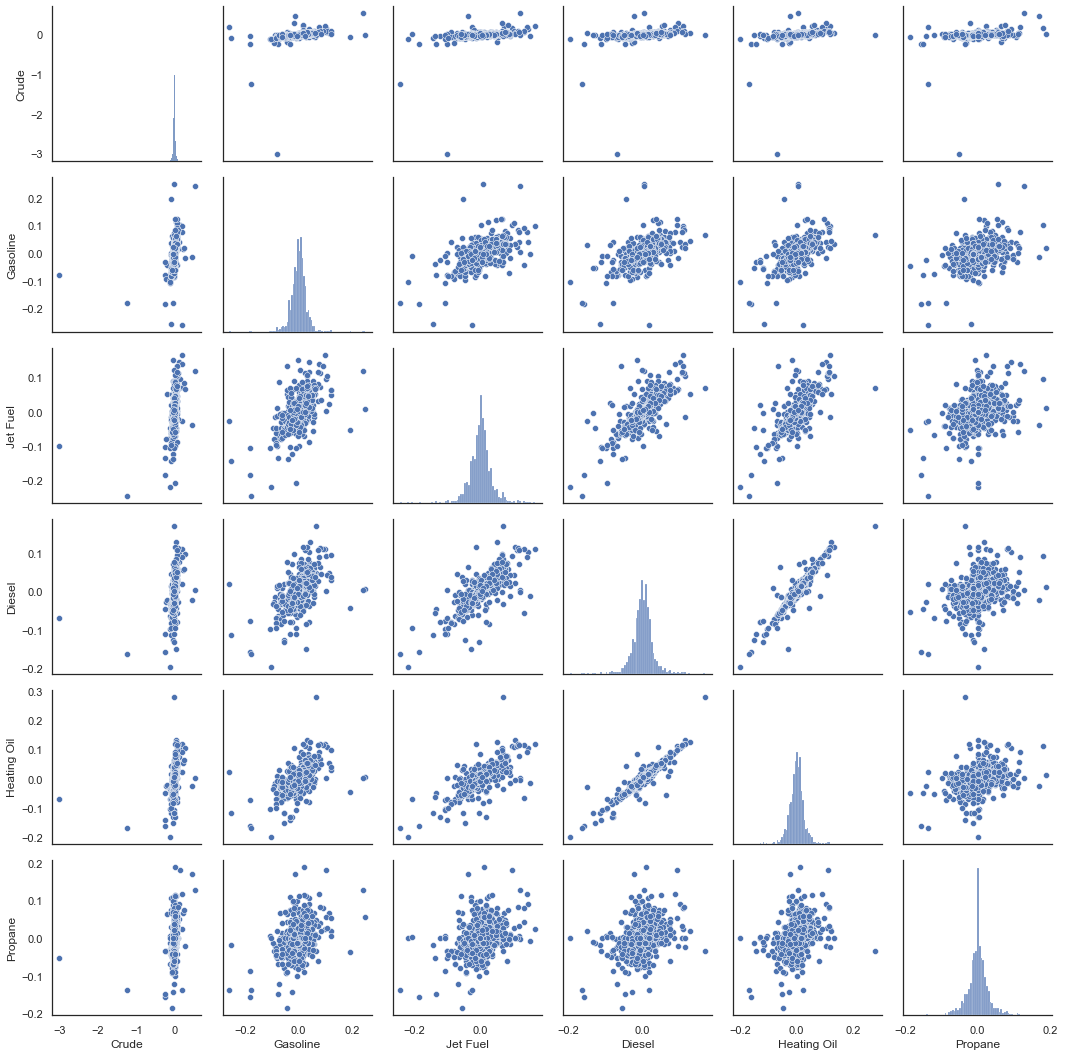

In [19]:
# Distribution of returns and scatterplots showing relationships between returns of various oil products
g = sns.PairGrid(wti_returns_df)
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)

## Key statistical metrics

In [20]:
# Creating empty DataFrame
stat_metrics = pd.DataFrame()

# Populating the dataframe with metrics
stat_metrics['Product'] = [item['name'] for item in products]
stat_metrics['Mean'] = wti_returns_df.mean().values
stat_metrics['Median'] = wti_returns_df.median().values
stat_metrics['Variance'] = wti_returns_df.var().values
stat_metrics['Skewness'] = stats.skew(wti_returns_df, axis=0, bias=True)
stat_metrics['Kurtosis'] = stats.kurtosis(wti_returns_df, axis=0, bias=True)

stat_metrics

,Product,Mean,Median,Variance,Skewness,Kurtosis
0,Crude,-0.001708,0.001907,0.010344,-22.816117,655.560535
1,Gasoline,0.001001,0.002016,0.001059,-0.328250,14.874791
2,Jet Fuel,0.001100,0.001554,0.001227,-0.454596,6.986535
3,Diesel,0.000905,0.001146,0.000875,-0.378241,6.571715
4,Heating Oil,0.000950,0.001520,0.001007,0.095364,9.778545
5,Propane,0.000532,0.000000,0.001007,0.095981,5.910215


The distributions with a higher kurtosis have heavier tails.

In [21]:
wti_returns_df.cov()

,Crude,Gasoline,Jet Fuel,Diesel,Heating Oil,Propane
Crude,0.010344,0.001056,0.001254,0.000950,0.001005,0.000793
Gasoline,0.001056,0.001059,0.000680,0.000576,0.000629,0.000414
Jet Fuel,0.001254,0.000680,0.001227,0.000831,0.000873,0.000423
Diesel,0.000950,0.000576,0.000831,0.000875,0.000889,0.000321
Heating Oil,0.001005,0.000629,0.000873,0.000889,0.001007,0.000340
Propane,0.000793,0.000414,0.000423,0.000321,0.000340,0.001007


In [22]:
sns.set_theme(style="white")
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Plot the correlation matrix using Seaborn heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)

# Show the plot
plt.title('Correlation Matrix - WTI Crude Oil/Oil Products Relationship')
plt.show()

NameError: name 'correlation_matrix' is not defined

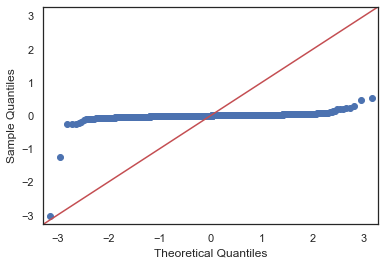

In [ ]:
# Plot Q-Q plot
fig = sm.qqplot(wti_returns_df['Crude'], line='45')
plt.show()

## Building ARIMA models

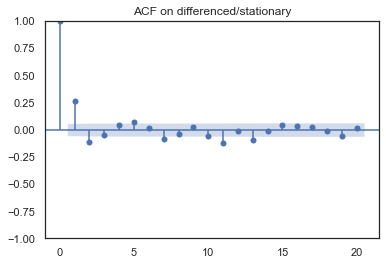

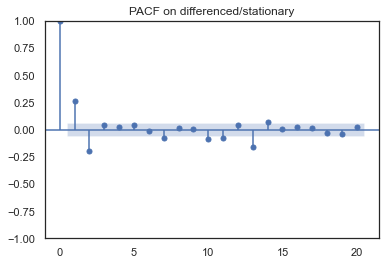

In [ ]:
# Plotting ACF and PACF functions
plot_acf(wti_returns_df['Crude'], lags=20,  title='ACF on differenced/stationary')
plot_pacf(wti_returns_df['Crude'], lags=20,  method='ols', title='PACF on differenced/stationary')

plt.show()

ACF and PACF plots indicate that multiple autocorrelations are significantly non-zero. By analyzing the spikes on the graph we chose parameters for our models. As a result orders p=1 and q=1 were selected for ARIMA model since there are significant spikes at lags 1 on both plots.

In [ ]:
model = ARIMA(wti_returns_df['Crude'], order=(1,0,1))
model_fit = model.fit()
print(model_fit.summary())

c:\Users\timda\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\timda\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\timda\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\timda\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\timda\anaconda3\lib\site-

                               SARIMAX Results                                
Dep. Variable:                  Crude   No. Observations:                 1215
Model:                 ARIMA(1, 0, 1)   Log Likelihood                1117.343
Date:                Fri, 01 Dec 2023   AIC                          -2226.685
Time:                        23:27:56   BIC                          -2206.275
Sample:                             0   HQIC                         -2219.002
                               - 1215                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0017      0.008     -0.212      0.832      -0.018       0.014
ar.L1         -0.1576      0.026     -6.010      0.000      -0.209      -0.106
ma.L1          0.4860      0.021     23.167      0.0

## Principal Components Analysis

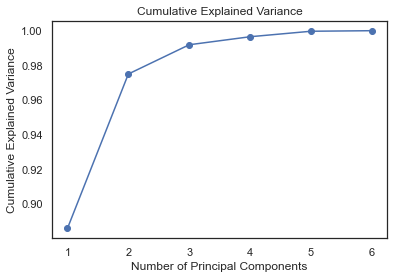

In [ ]:
# Standardize the Data
scaler = StandardScaler()
data_standardized = scaler.fit_transform(wti_df)

# Apply PCA
pca = PCA()
principal_components = pca.fit_transform(data_standardized)

# Explained Variance
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Plot explained variance
plt.plot(range(1, len(explained_variance_ratio) + 1), cumulative_explained_variance, marker='o')
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

In [ ]:
# Checking for missing values
dubai_crude_df.isna().value_counts()

Dubai Crude
False          406
dtype: int64

<AxesSubplot:xlabel='Date'>

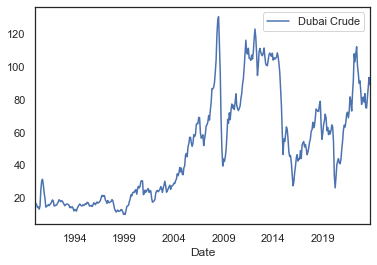

In [ ]:
dubai_crude_df.plot()